In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import threading

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipyparallel import Client 

from lib.solvers import LinearLMESolver
from lib.problems import LinearLMEProblem
from lib.visualizers import LMEModelVisualizer
from lib.bootstrappers import NonParLinearLMEBootstrapper

## LME Playground

In [4]:
study_sizes_widget = widgets.Text(value='100, 50, 10', placeholder="100, 100, 100", description='Study sizes:')
test_widget = widgets.IntSlider(min=1, max=20, value=10, step=1, description="Test size")
random_seed_widget = widgets.IntSlider(min=1, max=1000, value=498, step=1, description="Random seed")
num_features_widget = widgets.IntSlider(min=2, max=10, value=8, step=1, description="Features")
num_random_features_widget = widgets.IntSlider(min=1, max=6, value=2, step=1, description="Random effects")
obs_std_widget = widgets.FloatLogSlider(min=-5, max=0, value=0.1, step=0.2)
features_widget = widgets.HBox([num_features_widget, num_random_features_widget])
rest_widget = widgets.HBox([obs_std_widget, random_seed_widget])

mode_widget = widgets.ToggleButtons(options=['naive', 'fast'], 
                                         value='fast',
                                         description='Mode:')
method_widget = widgets.ToggleButtons(options=['gd', 'agd', 'nr', 'em'], 
                                         value='nr',
                                         description='Method:')
bootstrap_widget = widgets.ToggleButtons(options=['None', 'Parametric', 'Nonparametric', 'Analytic'], 
                                         value='None',
                                         description='Bootstrap:')
bootstrap_capacity_widget = widgets.IntSlider(min=10, max=1000, value=100, step=10, description="Bootstrap samples")
launch_log = []

def visualize_sample_problem(study_sizes="100, 100, 100",
                 test_size=5,
                 num_features=6, 
                 num_random_effects=3, 
                 obs_std=0.1, 
                 bootstrap='Nonparametric',
                 bootstrap_capacity=100,
                 mode='fast',
                 method='gd',
                 random_seed=42):
    figsize=(16, 16)
    if study_sizes == "":
        study_sizes = [study1, study2, study3]
    else:
        study_sizes = [int(s) for s in study_sizes.split(", ")]
    test_study_sizes = [test_size]*len(study_sizes)
    train, beta, gamma, random_effects, errs = LinearLMEProblem.generate(study_sizes=study_sizes,
                                                                         num_features=num_features,
                                                                         num_random_effects=num_random_effects,
                                                                         obs_std=obs_std,
                                                                         seed=random_seed)
    test = LinearLMEProblem.generate(study_sizes=test_study_sizes, beta=beta, gamma=gamma,
                                     true_random_effects=random_effects,
                                     seed=random_seed + 1, return_true_parameters=False)
    true_parameters = {
        "beta": beta,
        "gamma": gamma,
        "random_effects": random_effects,
        "errs": errs,
        "train": train,
        "test": test,
        "seed": random_seed
    }

    model = LinearLMESolver(mode=mode, method=method, tol=1e-8, max_iter=1000)
    if bootstrap == 'Nonparametric':
        bootstrapper = NonParLinearLMEBootstrapper(train, max_capacity=bootstrap_capacity, seed=random_seed)
    elif bootstrap == 'Parametric': 
        raise Excetion("Not implemented")
    elif bootstrap == 'Analytic':
        raise Excetion("Not implemented")
    else:
        bootstrapper=None
    
    progressbar=None
    if bootstrap != "None":
        progressbar = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
        progressbar.value=0
        display(progressbar)
        
    visualizer = LMEModelVisualizer()
    converged = visualizer.fit(model, train, test, true_parameters, bootstrapper, progressbar)
    
    if not converged:
        print("The main solver has not converged")
        return None

    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 4, wspace=0.3, hspace=0.3)
    prediction_plot = fig.add_subplot(grid[:2, :2])
    visualizer.plot_test_predictions(prediction_plot, with_confidences=False if bootstrapper is None else True)
    model_parameters_plot = fig.add_subplot(grid[0, 2])
    visualizer.plot_parameters(model_parameters_plot, with_confidences=False if bootstrapper is None else True)
    random_effects_plot = fig.add_subplot(grid[1, 2])
    visualizer.plot_random_effects(random_effects_plot, with_confidences=False if bootstrapper is None else True)
    gamma_plot = fig.add_subplot(grid[0, 3])
    visualizer.plot_gammas(gamma_plot, with_confidences=False if bootstrapper is None else True)  
    if num_random_effects == 2:
        gamma_trajectory_plot = fig.add_subplot(grid[2:4, 0:2])
        visualizer.plot_gamma_trace(gamma_trajectory_plot)
        #visualizer.plot_hessian(gamma_trajectory_plot, sufficient_criterion=True)
        gamma_hessian_pd_plot = fig.add_subplot(grid[2:4, 2:4])
        visualizer.plot_hessian(gamma_hessian_pd_plot)
    loss_plot = fig.add_subplot(grid[1, 3])
    visualizer.plot_loss(loss_plot)
    plt.show()
    
    hess_psd = []
    
    gamma_end = visualizer.logger["gamma"][-1]
    for alpha in linspace(0.1, 1, 20):
        beta0 = visualizer.model.optimal_beta(alpha*gamma_end)
        hessian = visualizer.model.hessian_gamma(beta0, alpha*gamma_end)
        eigvals = np.linalg.eigvals(hessian)
        conv_par = -1
        if np.linalg.norm(np.imag(eigvals)) > 1e-15:
            conv_par = -1
        min_eigval = min(np.real(eigvals))
        conv_par = min_eigval
        hess_psd.append(conv_par)
        
    print(hess_psd)
    
    launch_log.append(true_parameters)

In [5]:
interact_manual(visualize_sample_problem, 
                study_sizes = study_sizes_widget,
                test_size = test_widget,
                num_features = num_features_widget,
                num_random_effects = num_random_features_widget,
                obs_std = obs_std_widget,
                bootstrap = bootstrap_widget,
                bootstrap_capacity = bootstrap_capacity_widget,
                mode = mode_widget, 
                method = method_widget,
                random_seed = random_seed_widget)

interactive(children=(Text(value='100, 50, 10', description='Study sizes:', placeholder='100, 100, 100'), IntS…

<function __main__.visualize_sample_problem(study_sizes='100, 100, 100', test_size=5, num_features=6, num_random_effects=3, obs_std=0.1, bootstrap='Nonparametric', bootstrap_capacity=100, mode='fast', method='gd', random_seed=42)>

460, 199! change to abs loss!

## Figures for grant proposal

In [6]:
study_sizes_widget = widgets.Text(value='100, 50, 10', placeholder="100, 100, 100", description='Study sizes:')
test_widget = widgets.IntSlider(min=1, max=20, value=10, step=1, description="Test size")
random_seed_widget = widgets.IntSlider(min=1, max=1000, value=498, step=1, description="Random seed")
num_features_widget = widgets.IntSlider(min=2, max=10, value=8, step=1, description="Features")
num_random_features_widget = widgets.IntSlider(min=1, max=6, value=2, step=1, description="Random effects")
obs_std_widget = widgets.FloatLogSlider(min=-5, max=0, value=0.1, step=0.2)
features_widget = widgets.HBox([num_features_widget, num_random_features_widget])
rest_widget = widgets.HBox([obs_std_widget, random_seed_widget])

mode_widget = widgets.ToggleButtons(options=['naive', 'fast'], 
                                         value='fast',
                                         description='Mode:')
method_widget = widgets.ToggleButtons(options=['gd', 'agd', 'nr', 'em'], 
                                         value='nr',
                                         description='Method:')
bootstrap_widget = widgets.ToggleButtons(options=['None', 'Parametric', 'Nonparametric', 'Analytic'], 
                                         value='None',
                                         description='Bootstrap:')
bootstrap_capacity_widget = widgets.IntSlider(min=10, max=1000, value=100, step=10, description="Bootstrap samples")
launch_log = []

def visualize_sample_problem(study_sizes="100, 100, 100",
                 test_size=5,
                 num_features=6, 
                 num_random_effects=3, 
                 obs_std=0.1, 
                 bootstrap='Nonparametric',
                 bootstrap_capacity=100,
                 mode='fast',
                 method='gd',
                 random_seed=42):
    figsize=(8, 16)
    if study_sizes == "":
        study_sizes = [study1, study2, study3]
    else:
        study_sizes = [int(s) for s in study_sizes.split(", ")]
    test_study_sizes = [test_size]*len(study_sizes)
    train, beta, gamma, random_effects, errs = LinearLMEProblem.generate(study_sizes=study_sizes,
                                                                         num_features=num_features,
                                                                         num_random_effects=num_random_effects,
                                                                         obs_std=obs_std,
                                                                         seed=random_seed)
    test = LinearLMEProblem.generate(study_sizes=test_study_sizes, beta=beta, gamma=gamma,
                                     true_random_effects=random_effects,
                                     seed=random_seed + 1, return_true_parameters=False)
    true_parameters = {
        "beta": beta,
        "gamma": gamma,
        "random_effects": random_effects,
        "errs": errs,
        "train": train,
        "test": test,
        "seed": random_seed
    }

    model = LinearLMESolver(mode=mode, method=method, tol=1e-4, max_iter=1000)
    if bootstrap == 'Nonparametric':
        bootstrapper = NonParLinearLMEBootstrapper(train, max_capacity=bootstrap_capacity, seed=random_seed)
    elif bootstrap == 'Parametric': 
        raise Excetion("Not implemented")
    elif bootstrap == 'Analytic':
        raise Excetion("Not implemented")
    else:
        bootstrapper=None
    
    progressbar=None
    if bootstrap != "None":
        progressbar = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
        progressbar.value=0
        display(progressbar)
        
    visualizer = LMEModelVisualizer()
    converged = visualizer.fit(model, train, test, true_parameters, bootstrapper, progressbar)
    
    if not converged:
        print("The main solver has not converged")
        return None

    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    trajectory_plot = fig.add_subplot(grid[:, 1])
    visualizer.plot_gamma_trace(trajectory_plot)
    plt.show()
        
    launch_log.append(true_parameters)

In [7]:
interact_manual(visualize_sample_problem, 
                study_sizes = study_sizes_widget,
                test_size = test_widget,
                num_features = num_features_widget,
                num_random_effects = num_random_features_widget,
                obs_std = obs_std_widget,
                bootstrap = bootstrap_widget,
                bootstrap_capacity = bootstrap_capacity_widget,
                mode = mode_widget, 
                method = method_widget,
                random_seed = random_seed_widget)

interactive(children=(Text(value='100, 50, 10', description='Study sizes:', placeholder='100, 100, 100'), IntS…

<function __main__.visualize_sample_problem(study_sizes='100, 100, 100', test_size=5, num_features=6, num_random_effects=3, obs_std=0.1, bootstrap='Nonparametric', bootstrap_capacity=100, mode='fast', method='gd', random_seed=42)>

## May not work with 

seed = 623, 840

## Convex path to zero

In [9]:
n = 3000
logs = []
for random_seed in range(n):
    log = {
            "seed": random_seed, 
            "alpha": []
          }
    train, beta, gamma, random_effects, errs = LinearLMEProblem.generate(seed=random_seed)
    model = LinearLMESolver(method="nr", mode="fast", tol=1e-4, max_iter=1000)
    try:
        logger = model.fit(train)
        if not logger["converged"]:
            continue
        end_gamma = logger["gamma"][-1]
        for alpha in linspace(0.1, 1, 100):
            beta0 = model.optimal_beta(alpha*end_gamma)
            hessian = model.hessian_criterion(beta0, alpha*end_gamma)
            eigvals = np.linalg.eigvals(hessian)
            conv_par = -1
            #if np.linalg.norm(np.imag(eigvals)) > 1e-15:
            #    conv_par = -1
            min_eigval = min(np.real(eigvals))
            conv_par = min_eigval
            log["alpha"].append(conv_par)
    except Exception:
        continue

    logs.append(log)
print(len(logs))

/Users/aksh/Storage/repos/dismod_research/experiments/lib/solvers.py:95: RuntimeWarning: invalid value encountered in double_scalars
  result += 1 / 2 * xi.T.dot(omega_inv).dot(xi) - 1 / 2 * sign * determinant


2823


In [10]:
print(mean([min(log["alpha"]) < 0 for log in logs]))

0.01983705278072972


It actually exists

In [115]:
for i, log in enumerate(logs):
    if min(log["alpha"]) < 0:
        print(i, log["alpha"][:4])

326 [-1.3454178418390788e-15, 2.7707814698241958e-15, -7.280936627962823e-17, 2.8067508501487992e-15]
818 [-2481.469197314991, -2252.691937654658, -1964.9312613549916, -1654.0434675346976]
845 [183.56820429379107, 166.27953108585257, 151.32988046319204, 138.25384641914664]
868 [-4.541928245043265e-26, -2.6066367690914314e-25, 2.077986988781667e-25, -1.021371405398406e-24]
1009 [-166.6261375065178, 730.5764976632518, 1406.6091411098619, 1802.9766573464046]
1099 [-1.6887532759406574e-29, -7.737352540762743e-29, 1.6981268299560025e-29, 4.0340738293877955e-29]
1182 [-409.9308057015502, -208.294967695414, -23.158019866217558, 137.43239401237253]
1341 [-1.2031480622219504e-26, 2.5588644159737155e-26, -39.96700861675007, -47.44612905269571]
1444 [1.4050317432301083e-28, -4.4336352522217e-24, -3.083672149415787e-17, -5.678360529702028e-24]
1496 [-0.8366025577957932, -0.854322319272935, -1.1046933339167164, -1.2350703412488924]
1557 [-1.4136308608769413e-28, 1.4017848597844877e-29, -1.019269542

## Difference between minimas (unfinished)

In [61]:
max_num_studies = 100
num_features = 7
num_random_effects = 2
obs_std = 0.1
gammas = []
for j in range(2, 5, max_num_studies):
    study_sizes = [50]*j
    train, beta, gamma, random_effects, errs = LinearLMEProblem.generate(study_sizes=study_sizes,
                                                                         num_features=num_features,
                                                                         num_random_effects=num_random_effects,
                                                                         obs_std=obs_std,
                                                                         seed=j)
    true_empirical_gamma = np.sum(random_effects ** 2, axis=0)/i
    #true_empirical_gamma = np.var(random_effects, axis=0)
    true_gamma = gamma 
    alg1 = LinearLMESolver(method="gd")
    alg2 = LinearLMESolver(method="empirical")
    alg1.fit(train)
    alg2.fit(train)
    gammas.append((true_gamma, true_empirical_gamma, alg1.gamma, alg2.gamma))

In [62]:
true_gamma_dists = []
empirical_gamma_dists = []
for true_gamma, empirical_gamma, gamma1, gamma2 in gammas:
    if gamma1 is None or gamma2 is None:
        continue
    true_gamma_dists.append((norm(true_gamma - gamma1), norm(true_gamma - gamma2)))
    empirical_gamma_dists.append((norm(empirical_gamma - gamma1), norm(empirical_gamma - gamma2)))
true_gamma_dists = array(true_gamma_dists).T
empirical_gamma_dists = array(empirical_gamma_dists).T

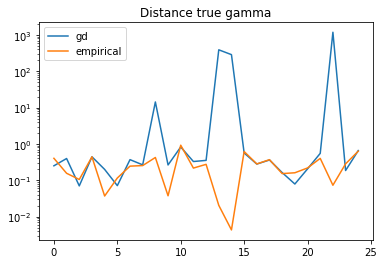

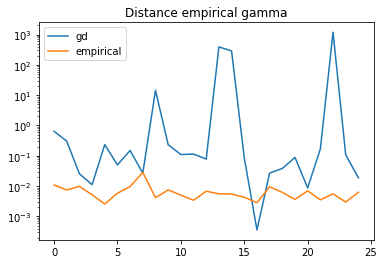

In [64]:
nn = len(true_gamma_dists[0])
semilogy(range(nn), true_gamma_dists[0], label="gd")
semilogy(range(nn), true_gamma_dists[1], label="empirical")
plt.title("Distance true gamma")
plt.legend()
plt.show()
semilogy(range(nn), empirical_gamma_dists[0], label="gd")
semilogy(range(nn), empirical_gamma_dists[1], label="empirical")
plt.title("Distance empirical gamma")
plt.legend()
plt.show()

## Correct gamma inference in EM algorithm

In [112]:
gamma = array([0.5, 1, 2])

In [124]:
emp_gammas = []

for i in range(3, 200):
    us = randn(i, 3)*sqrt(gamma)
    emp_gamma = np.sum(us ** 2, axis=0)/i
    emp_gammas.append(emp_gamma)

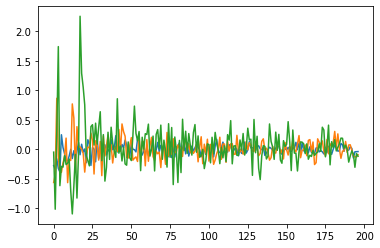

In [125]:
plot(emp_gammas - gamma)

## Convexity of the losss

In [1]:
β = 3